# Poroviscoelastic Tides of Io - Julia Notebook
### Hamish Hay (hamish.hay@earth.ox.ac.uk)

This is an accompanying Julia notebook to the paper "Poroviscoelastic Tides of Io" by Hay, Hewitt, Rovira-Navarro, and Katz. This notebook reproduces all figures in the manuscript.

In [25]:
include("../TidalLoveNumbersPorousK23.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall
using BenchmarkTools
using LinearAlgebra
    
@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec

PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

#mpl.style.use("dark_background")

# Get precision of love number calculations
prec = TidalLoveNumbers.prec    # Real
precc = TidalLoveNumbers.precc; # Complex

In [2]:
# Convenience function for returning internal structure based on 
# asthensphere thickness
function get_internal_structure(asthenosphere_thickness)    # Input is in km
    R = 1820.0
    r_cmb = 700.0
    r_crust = 1800.0
    r_asthenosphere = r_crust - asthenosphere_thickness

    return [0, r_cmb, r_asthenosphere, r_crust, R] .* 1e3
end;

# Convenience function to calculate the complex moduli for a 
# poroviscoelastic compacting material
function get_complex_moduli(μ, η, κd, ζ, κs, ω)
    μc = zeros(precc, length(μ))
    κdc = zero(μc)
    αc = zero(μc)
    
    for i in 1:length(μ) 
        μc[i]  =  isinf(η[i]) ? μ[i] : 1im*ω*μ[i] / (1im*ω + μ[i] / η[i])
        κdc[i] =  isinf(ζ[i]) ? κd[i] : 1im*ω*κd[i] / (1im*ω + κd[i] / ζ[i])
        αc[i]  = 1.0 - κdc[i] / κs[i]
    end
    
    return μc, κdc, αc
end

get_complex_moduli (generic function with 1 method)

## Define main material parameters for each layer

In [26]:
n = 2
ω = 2 * 2.05e-5
ecc = 0.0048
nr = 500

# Solid material parameters -------------------------------------------
ρs = prec[3300, 3300, 3300, 3300]   # Solid density
μ = prec[60, 60, 60, 60] .* 1e9     # Shear modulus
κs = prec[100, 100, 100, 100].*1e9  # Solid bulk modulus
η = prec[1e25, 1e18, 1e15, 1e25]    # Solid shear viscosity
ζ = prec[1e25, 1e25, 1e25, 1e25]    # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 100e9, 0] .* 100000.0   # Liquid bulk modulus
κd = 0.05κs                         # Drained bulk modulus
k = [0, 0, 1e-7, 0]                 # Permeability
α = 1.0 .- κd/κs                    # Biot's modulus

ηl = [0, 0, 100, 0]                 # Liquid viscosity
ϕ =  [0, 0, prec(0.1), 0]           # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

D = 300                              # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure

R = r[end]                          # Mean radius 
rr = expand_layers(r, nr=nr)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);                   # Calculate g at each secondary layer

# Total Heating Rate

## vs. Mobility

In [27]:
μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)


k = [0, 0, 1e-12, 0]
# y1 = ComplexF64.(calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k));
y1 = ComplexF64.(calculate_y(rr, ρ, g, μc, κs));

get_total_heating(y1, ω, R, ecc)
E1, E2 = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ecc)

# y1[:,end,end]
# y1[5,end,end]-1

([0.0, 3.011287156647595e-8, 3.442073927240925e-6, 4.295155708732189e-16], [0.0 8.673543154587074e-8 7.816945509899781e-6 4.3922497278221076e-16; 0.0 8.573323526433404e-8 7.787546110933109e-6 4.3918279028709356e-16; … ; 0.0 1.3132685340480763e-8 1.5291597432127612e-6 4.207445240096661e-16; 0.0 0.0 0.0 0.0])

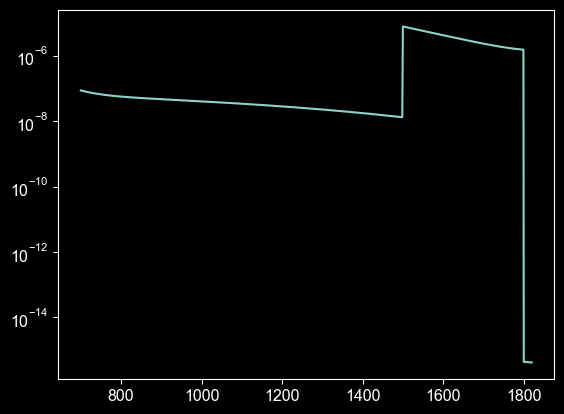

In [28]:
fig, ax = subplots()
semilogy(rr[1:end-1,2:end][:]./1e3, E2[1:end-1,2:end][:])
display(fig)

In [16]:
E2

6×4 Matrix{Float64}:
 0.0  8.7256e-15   3.20614e-6  7.86331e-16
 0.0  5.82497e-15  3.06705e-6  7.75763e-16
 0.0  3.50181e-15  2.93703e-6  7.65361e-16
 0.0  2.01061e-15  2.81565e-6  7.55122e-16
 0.0  1.06985e-15  2.70258e-6  7.45044e-16
 0.0  0.0          0.0         0.0

In [37]:
k = [0, 0, 1e-6, 0]
y1 = ComplexF64.(calculate_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k));
y1[:,end,end]
y1[5,end,end]-1


0.033716597230781575 - 1.8131483965158801e-7im

In [54]:
y1 = ComplexF64.(calculate_y(rr, ρ, g, μ, κ, ω, ρₗ, κₗ,κd,α, ηₗ, ϕ, k));

4-element Vector{Complex{Double64}}:
 2.98078393218724566364574572623529703e-13 - 7.80694696715166970142389270964626314e-21im
 6.62598464237650076284373152326003475e-05 - 6.43865190711379923353184004067644069e-10im
 3.33645525662176723650325458708266491e-03 - 1.11050552277519486823841694352343001e-09im
 1.85430181241356342248624531942437694e+03 - 9.33482900692194290269950956407478348e+02im

In [25]:
P*D3*D2*(D1*Ic + Bp2) + P2*D2*(D1*Ic + Bp2)
(P*D3 + P2)*D2*(D1*Ic + Bp2)

4×4 Matrix{Complex{Double64}}:
  -2.030246293939968e21 + 9.34048830098404e15im   …  -4.7320255230432086e-5 + 7.314400009724664e-6im
   6.506549908054825e21 - 4.425538103314862e15im      3.0067094181605367e-5 + 2.673382933499176e-7im
 -2.0509798579888925e11 - 750912.8686811159im         3.836768918852538e-17 - 3.924497350526136e-15im
   6.924358800440116e13 + 3.381290225392138e12im      -5.124826641070161e-9 + 1.396789282442257e-8im

In [7]:
Iφ = zeros(precc, 8, 8)

for i in 1:6
    Iφ[i,i] = 1
end

for i in 2:2
    B = zeros(precc, 8, 8)
    
    Iφ[7,7] = ϕ[i] > 0 ? 1 : 0
    Iφ[8,8] = ϕ[i] > 0 ? 1 : 0


    r1 = rr[1,i]
    for j in 1:3#nr-1
        r2 = rr[j+1,i]
        dr = r2 - r1
        rhalf = r1 + 0.5dr

        r2 = rr[j+1, i]
        g1 = g[j, i]
        g2 = g[j+1, i]

        # if iszero(ϕ[i])  
        #     B[1:6,1:6] .= get_B(r1, r2, g1, g2, ρ[i], μ[i], κ[i]) * (j==1 ? B1[1:6,1:6] : B[1:6,1:6])
        # else
        A = Iφ * get_A(r1, g1, ρ[i], μ[i], κ[i], ω, ρₗ[i], κₗ[i], κd[i], α[i], ηₗ[i], ϕ[i], k[i]) * Iφ

        k18 = dr * A 
        k28 = dr *  (A .+ 0.5A *k18) # dr*A + 0.5dr*A*k188
        k38 = dr *  (A .+ 0.5*A *k28)
        k48 = dr *  (A .+ A*k38) 

        B = (I + 1.0/6.0 .* (k18 .+ 2*(k28 .+ k38) .+ k48))
        # B = (I + 1.0/6.0 .* (k18 .+ 2*(k28 .+ k38) .+ k48))
        # B = get_B(r1, r2, g1, g2, ρ[i], μ[i], κ[i], ω, ρₗ[i], κₗ[i], κd[i], α[i], ηₗ[i], ϕ[i], k[i]) 
        # println(ϕ[i])
        display(A)
        # end

        r1 = r2
    end
# end

    # D[:,:,i-1] .= B
end


8×8 Matrix{Complex{Double64}}:
 -0.0001999520076787714 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
                -0.0001 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
      7198.836006115696 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
    -3599.4210476015523 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
  7.737913321182261e-12 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
 2.3213739963546786e-15 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
                    0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
                    0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im

8×8 Matrix{Complex{Double64}}:
 -0.00013359822339338844 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
   -6.681514476614699e-5 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
      3213.7433914212966 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
     -1606.8747402543524 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
  1.1581076937369453e-11 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
  2.3213739963546786e-15 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
                     0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
                     0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im

8×8 Matrix{Complex{Double64}}:
 -0.00010031037174520305 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
   -5.016722408026756e-5 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
      1811.7582063458992 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
      -905.8821477166539 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
   1.542424055355664e-11 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
  2.3213739963546786e-15 + 0.0im  …  0.0 + 0.0im  0.0 + 0.0im
                     0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im
                     0.0 + 0.0im     0.0 + 0.0im  0.0 + 0.0im

In [5]:
nlayer = 3

nr = 301

Iφ = zeros(precc, 8, 8)

for i in 1:6
    Iφ[i,i] = 1
end




B1 = zeros(precc, 8, 8)
for i in 1:6
    B1[i,i] = 1.0
end

D = zeros(precc, 8, 8, 3)
# for i in i1:iend # start at the top of the innermost layer

for i in 2:4
    B = zeros(precc, 8, 8)
    r1 = rr[1,i]

    Iφ[7,7] = ϕ[i] > 0 ? 1 : 0
    Iφ[8,8] = ϕ[i] > 0 ? 1 : 0
    for j in 1:nr-1
        r2 = rr[j+1,i]
        dr = r2 - r1
        rhalf = r1 + 0.5dr

        r2 = rr[j+1, i]
        g1 = g[j, i]
        g2 = g[j+1, i]

        if iszero(ϕ[i])  
            B[1:6,1:6] .= get_B(r1, r2, g1, g2, ρ[i], μ[i], κ[i]) * (j==1 ? B1[1:6,1:6] : B[1:6,1:6])
        else
            B[:,:]     .= get_B(r1, r2, g1, g2, ρ[i], μ[i], κ[i], ω, ρₗ[i], κₗ[i], κd[i], α[i], ηₗ[i], ϕ[i], k[i]) * (j==1 ? I : B)
        end

        r1 = r2
    end
# end

    D[:,:,i-1] .= B
end


In [6]:
Bp = zeros(8);
Bp[7] = 1.0;
Bp2 = zeros(8,4)
Bp2[7,4] = 1.0;


Ic = get_Ic(rr[end,1], ρ[1], g[end,1], μ[1], "liquid", 8, 4)

n=2
b = zeros(precc, 4)
b[3] = (2n+1)/r[end,end];

P = zeros(4, 8)
P[1,3] = 1.0
P[2,4] = 1.0
P[3,6] = 1.0
P[4,8] = 0.0

P2 = zeros(4, 8)
P2[4,8] = 1.0

D1 = D[:,:,1];
D2 = D[:,:,2];
D3 = D[:,:,3];

In [9]:
Bp2

8×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0

In [16]:
Ic*C

8-element Vector{Complex{Double64}}:
 1.05564873180145262644064130503121775e-04 - 1.02588553536906105468706808916142921e-09im
 6.62598464237650055280425216279157071e-05 - 6.43865190711379902943068898310653365e-10im
 1.01579838462546417938769015598301973e-01 - 3.38098259796498570904118143574161613e-08im
                                       0.0 + 0.0im
 2.98078393218724556915679973921995514e-05 - 7.80694696715166945394866029274559716e-13im
 1.51960986336968934217981175921433617e-08 - 3.22975948294756606908408824651316479e-15im
                                       0.0 + 0.0im
                                       0.0 + 0.0im

In [19]:
D2*(D1*Ic+Bp2)*C

8-element Vector{Complex{Double64}}:
 2.59248467371059530351823119486190888e-02 - 4.17054505256868270857942536654908712e-07im
  7.9570780980223169680664020021824308e-03 + 1.32166427727115584320289960955220831e-07im
 6.15007553709420246614806117912969478e+01 + 3.53551578899649699631228099172220805e-03im
 2.98525276475011086876381038303754092e+01 - 1.98742673494368942022040807533872055e-03im
     1.00397813892934897912045246953805346 - 3.93413950063978370026431401483776876e-07im
 2.71613439562975918702535930072794131e-06 + 6.18625619490540297363668151840640414e-14im
 2.83742658577358315791812583179985335e+03 - 9.4508025655655009269080822268262208e+02im
                     8.097703166147945e-31 + 4.150487175634769e-32im

In [13]:
# P2*D2*(D1*Ic + Bp2) extracts the Dary flux component associated with the fourth constant at the top of the porous layer
# P*D3*D2*(D1*Ic + Bp2) extracts the third, fourth and sixth components at the surface

M = (P*D3 + P2)*D2*(D1*Ic + Bp2)
C = M \ b

4-element Vector{Complex{Double64}}:
 2.98078393218724556915679973921995076e-13 - 7.80694696715166945394866029274556174e-21im
 6.62598464237650055280425216279157071e-05 - 6.43865190711379902943068898310653365e-10im
 3.33645525662176713073975488142788121e-03 - 1.11050552277519483303610147659494962e-09im
 1.85430181241356336370606272079780105e+03 - 9.3348290069219426067913951498726144e+02im

In [34]:
D3*D2*(D1*Ic + Bp2)*C

8-element Vector{Complex{Double64}}:
 2.58736095016631318076057749551933192e-02 - 3.99089239365898453713901753726087895e-07im
 7.76271518807179529325479778293365783e-03 + 1.37838095886836360070373619192809787e-07im
                   -1.4558516358275158e-23 + 4.415266972528958e-29im
                     6.528814285063869e-24 + 5.755676423360922e-29im
     1.02639452689339190670576207696128195 - 4.02197909720942688772920065206962764e-07im
 2.74725274725274716566109610267881013e-06 - 1.4810379521387565e-38im
                                       0.0 + 0.0im
                                       0.0 + 0.0im